Imports

In [ ]:
import os
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=a0cefb53fc29d58eedaa6cf77c997db8d950aabb712c0e770009449d2afdf405
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!wandb login "YOUR API KEY"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Getting Data + Authentication

In [ ]:
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d dataset

Saving kaggle.json to kaggle.json
100% 2.29G/2.29G [01:41<00:00, 25.4MB/s]
100% 2.29G/2.29G [01:41<00:00, 24.2MB/s]


Defining paths to the data

In [ ]:
train_path = "dataset/chest_xray/train"
val_path = "dataset/chest_xray/val"
test_path = "dataset/chest_xray/test"

Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

Preparing the data

In [ ]:
test_validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale')

test_generator = test_validation_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale')

validation_generator = test_validation_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
!ls dataset/chest_xray


Counting Normal vs Pneumonia images

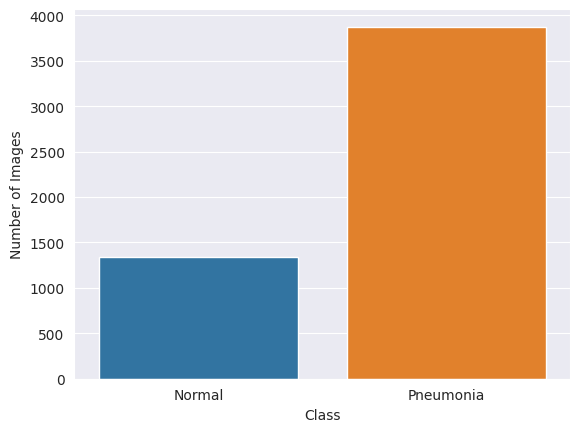

In [ ]:
num_normal_images = len(os.listdir(train_path + "/NORMAL"))
num_abnormal_images = len(os.listdir(train_path + "/PNEUMONIA"))

sns.set_style('darkgrid')
sns.barplot(x=['Normal', 'Pneumonia'], y=[num_normal_images, num_abnormal_images])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

Normal patient vs Pneumonic patient

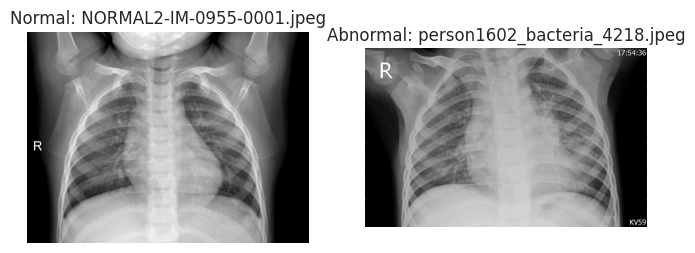

In [ ]:
normal_path = 'dataset/chest_xray/train/NORMAL/'
abnormal_path = 'dataset/chest_xray/train/PNEUMONIA/'

normal_image = random.choice(os.listdir(normal_path))
abnormal_image = random.choice(os.listdir(abnormal_path))

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(normal_path + normal_image), cmap='gray')
plt.title('Normal: ' + normal_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(abnormal_path + abnormal_image), cmap='gray')
plt.title('Abnormal: ' + abnormal_image)
plt.axis('off')

plt.show()

Defining our models

In [ ]:
from keras.regularizers import l2

def build_block(model, filters, input_shape=None):
    if input_shape:
        model.add(Conv2D(filters, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    else:
        model.add(Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    return model

def model1():
    model = Sequential()
    model = build_block(model, 32, (150, 150, 1))
    model.add(Dropout(0.2))
    model = build_block(model, 64)
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def model2():
    model = Sequential()
    model = build_block(model, 32, (150, 150, 1))
    model.add(Dropout(0.2))
    model = build_block(model, 64)
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


models = [model1(), model2()]
best_model = None
best_accuracy = 0

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_52 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 dropout_66 (Dropout)        (None, 75, 75, 32)        0         
                                                                 
 conv2d_53 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_53 (Bat  (None, 75, 75, 64)     

Training + Evaluation of models

In [ ]:
import wandb
from wandb.keras import WandbCallback
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Defining callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint_path = '/content/gdrive/MyDrive/ModelsML/model_{epoch:02d}_val_loss_{val_loss:.4f}.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

for i, model in enumerate(models):
    print(f"Training model {i+1}")

    # Initializing a new run for each model
    run = wandb.init(project="PneumoniaDetection-Chest-X-Ray", config={"model_index": i+1})

    model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[lr_scheduler, early_stopping, WandbCallback(), model_checkpoint]
    )

    # Evaluating the model on the validation set
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

    # Loging the validation loss and accuracy to WandB
    wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})

    # Saving the entire model
    model.save(f"/content/gdrive/MyDrive/ModelsML/full_model_{i+1}.h5")

    # Finishing the model run
    run.finish()

Predicted vs True

1/1 [==============================] - 0s 22ms/step


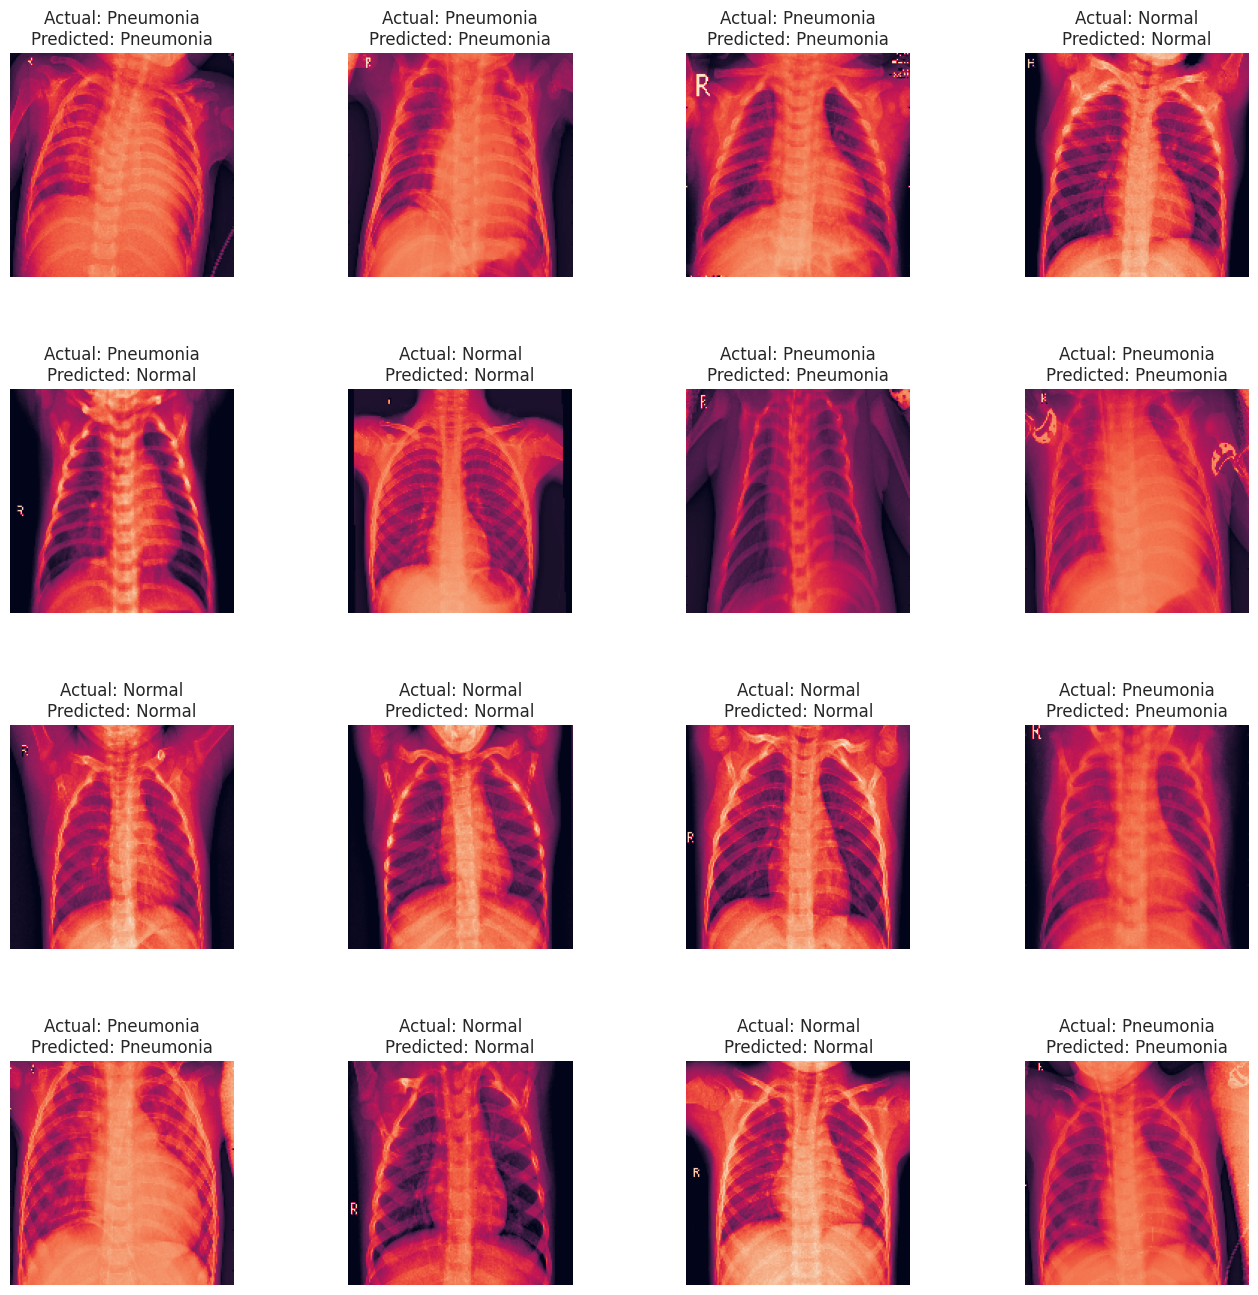

In [ ]:
test_images, test_labels = next(test_generator)
test_predictions = models[1].predict(test_images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    ax.axis('off')
    ax.set_title('Actual: ' + ('Normal' if test_labels[i] == 0 else 'Pneumonia') +
              '\nPredicted: ' + ('Normal' if test_predictions[i] < 0.5 else 'Pneumonia'))

plt.show()